In [1]:
import numpy as np
import model

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

from mrashpen.inference.penalized_regression import PenalizedRegression as PLR
from mrashpen.inference.mrash_wrapR          import MrASHR
from mrashpen.models.plr_ash                 import PenalizedMrASH
from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled
from mrashpen.inference.ebfit                import ebfit
from mrashpen.inference                      import lbfgsfit
from mrashpen.utils                          import R_lasso
from mrashpen.utils                          import R_trendfilter

def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

Signal-to-noise ratio: 0.046


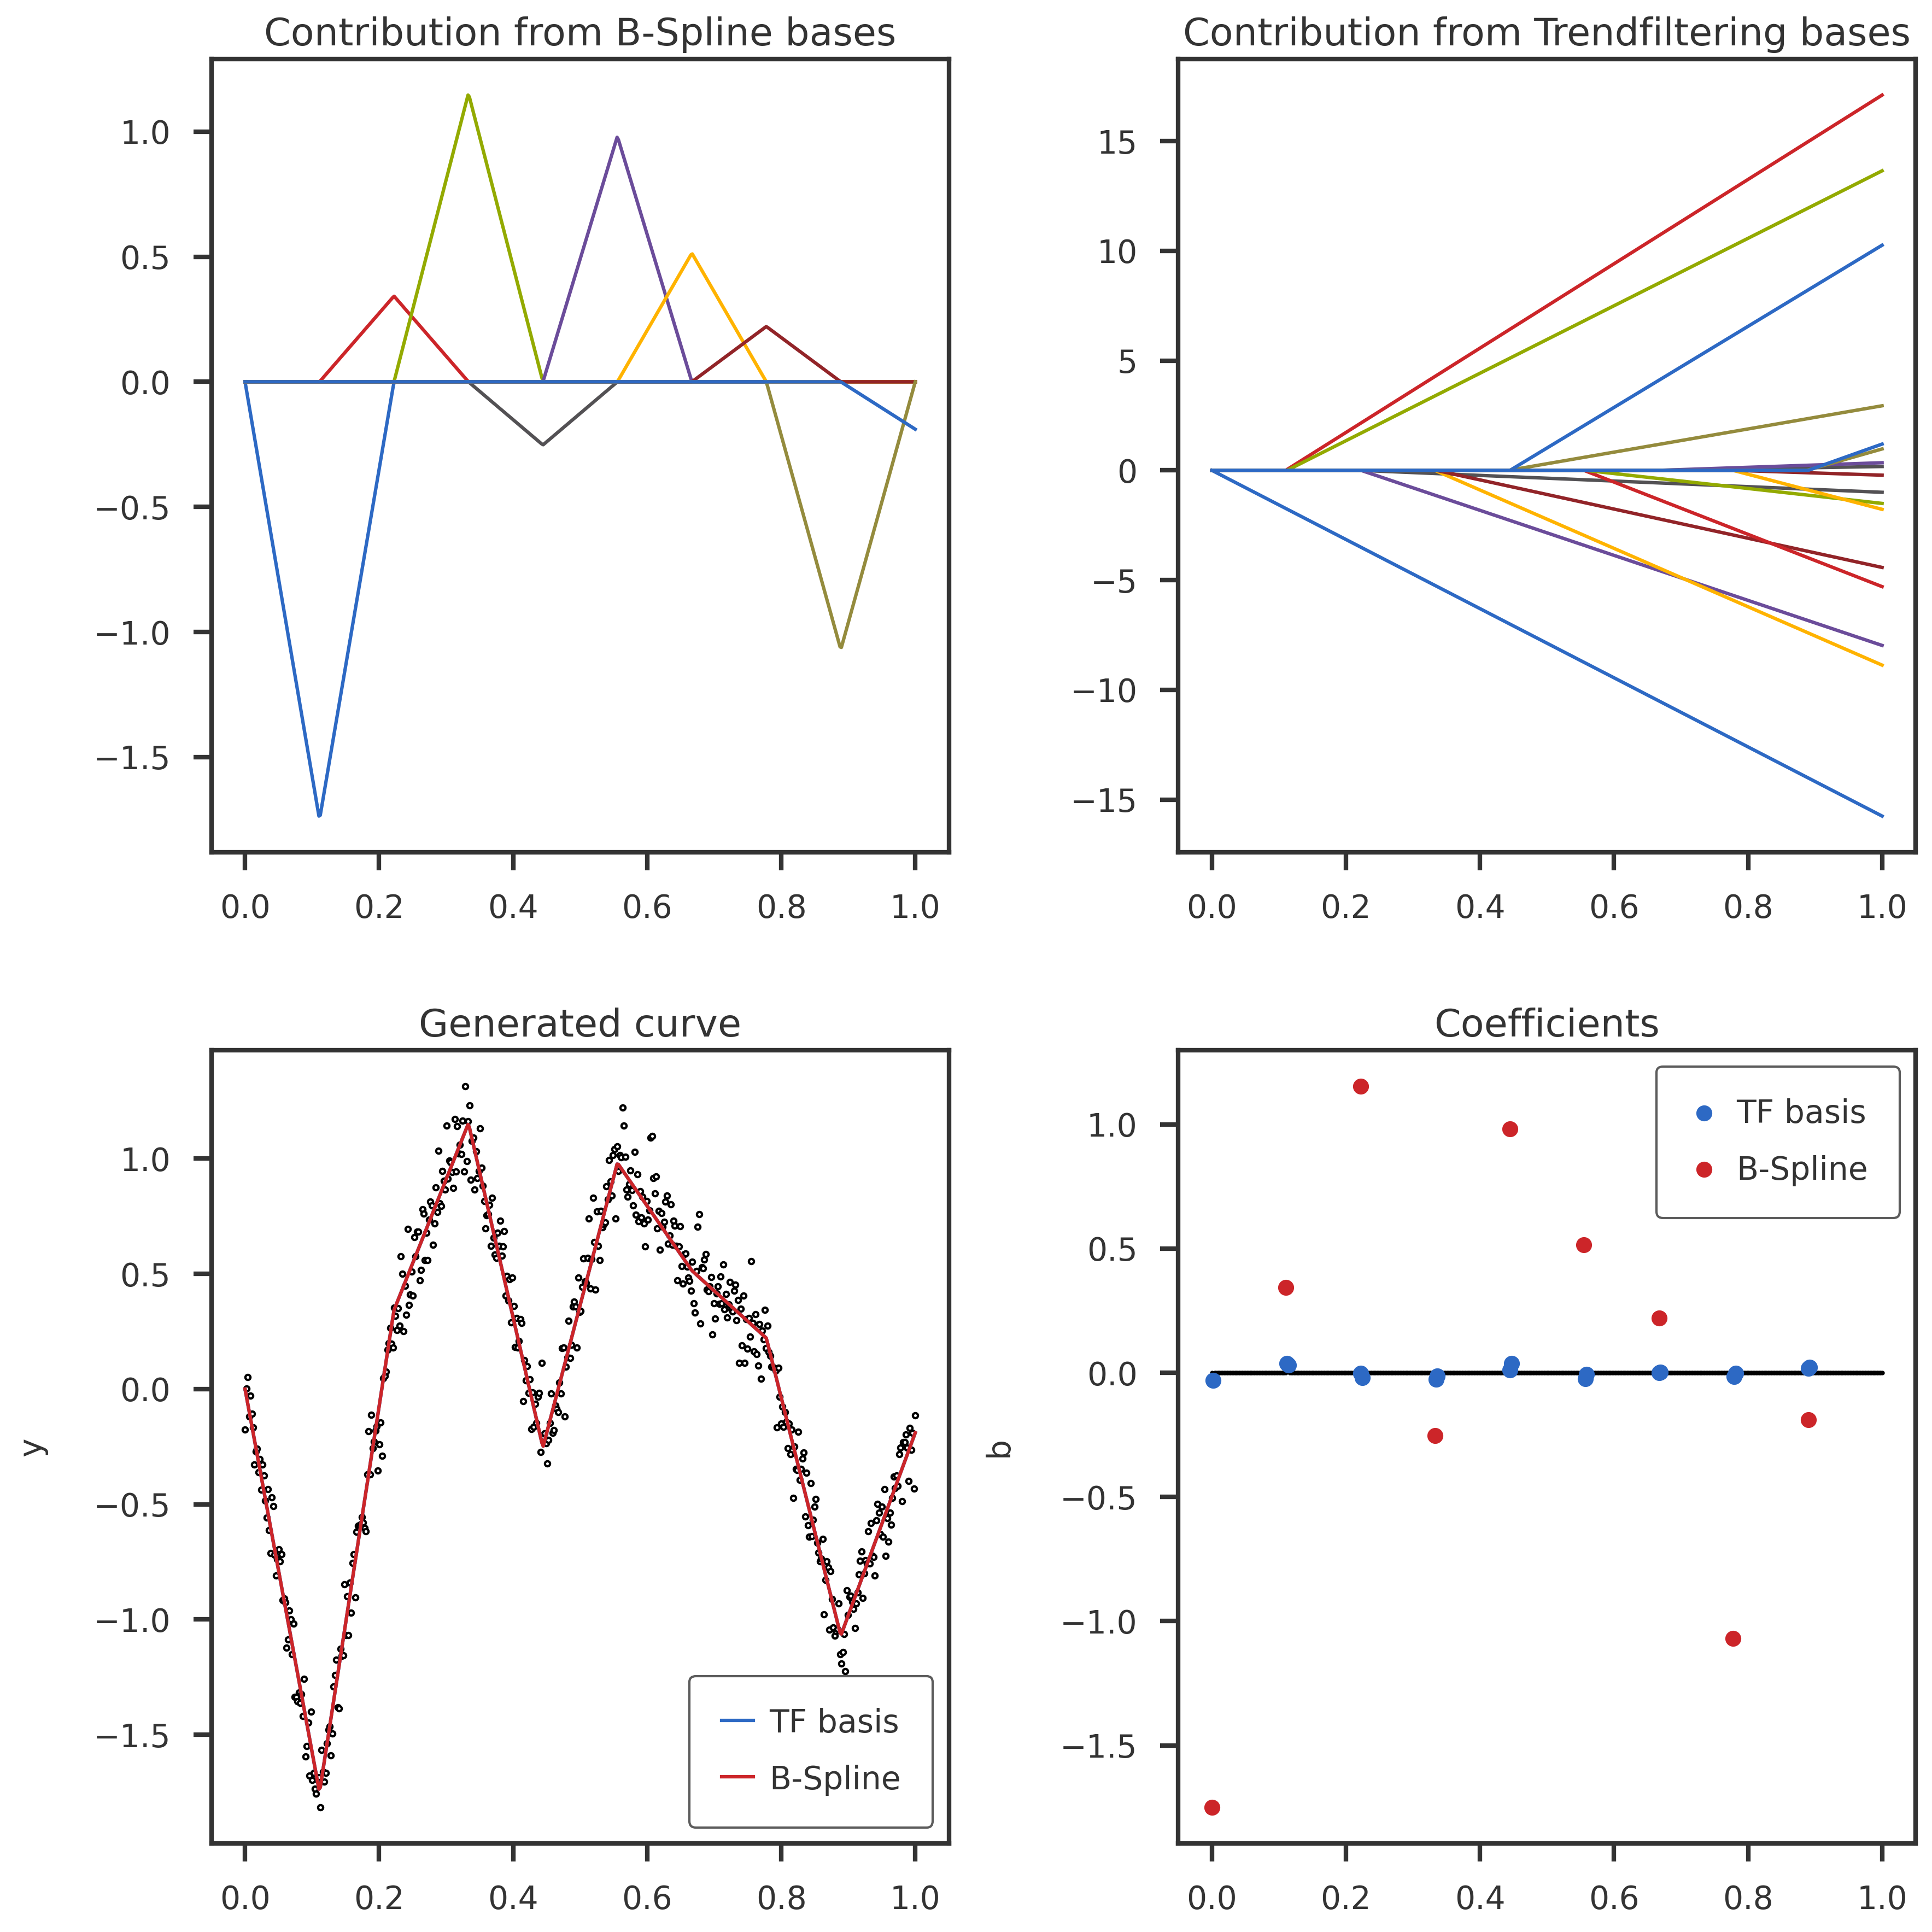

In [2]:
n = 500
x = np.linspace(0, 1, n)
np.random.seed(100)

# Zeroth degree trendfiltering
nknots = 8
degree = 1
strue = 0.1
include_intercept = False
knots = np.linspace(0, 1, nknots+2)[1:-1]
bfix = np.random.normal(0, 1, size = nknots + degree)


H, y, ytest, btrue, snr, G, Gb = model.changepoint_from_bspline(x, knots, strue, 
                                            degree = degree, 
                                            signal = "fixed", bfix = bfix,
                                            seed = 100, include_intercept = include_intercept,
                                            get_bsplines = True, eps = 1e-8
                                           )
print(f"Signal-to-noise ratio: {snr:.3f}")

fig = plt.figure(figsize = (12, 12))
axlist = [fig.add_subplot(2,2,i+1) for i in range(4)]
model.plot_data_from_bspline(axlist, x, y, knots, degree, G, Gb, H, btrue, show_base_legend = False)
plt.tight_layout()
plt.subplots_adjust(hspace = 0.25)
plt.show()

In [3]:
def center_and_scale_tfbasis(Z, b):
    '''
    Basis matrix Z is always 2D.
    b is the coefficient vector
    The first column of Z is all 1, hence it has zero standard deviation.
    '''
    dim  = Z.ndim
    std  = np.std(Z, axis = 0)
    if std[0] == 0:
        # do not scale the first column
        std[0] = 1.0
    Znew = Z / std
    Znew[:, 1:] = Znew[:, 1:] - np.mean(Znew[:, 1:], axis = 0).reshape(1, -1)
    bnew = b * std
    ## add the intercept
    bnew[0] = - np.sum(Znew[0, :] * bnew)
    '''
    alternative
    bnew = np.dot(np.dot(np.linalg.inv(Znew), Z), b)
    '''
    return Znew, bnew

Hscale, bscale = center_and_scale_tfbasis(H, btrue)
dj = np.sum(np.square(Hscale), axis = 0)
print (dj)

[500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 

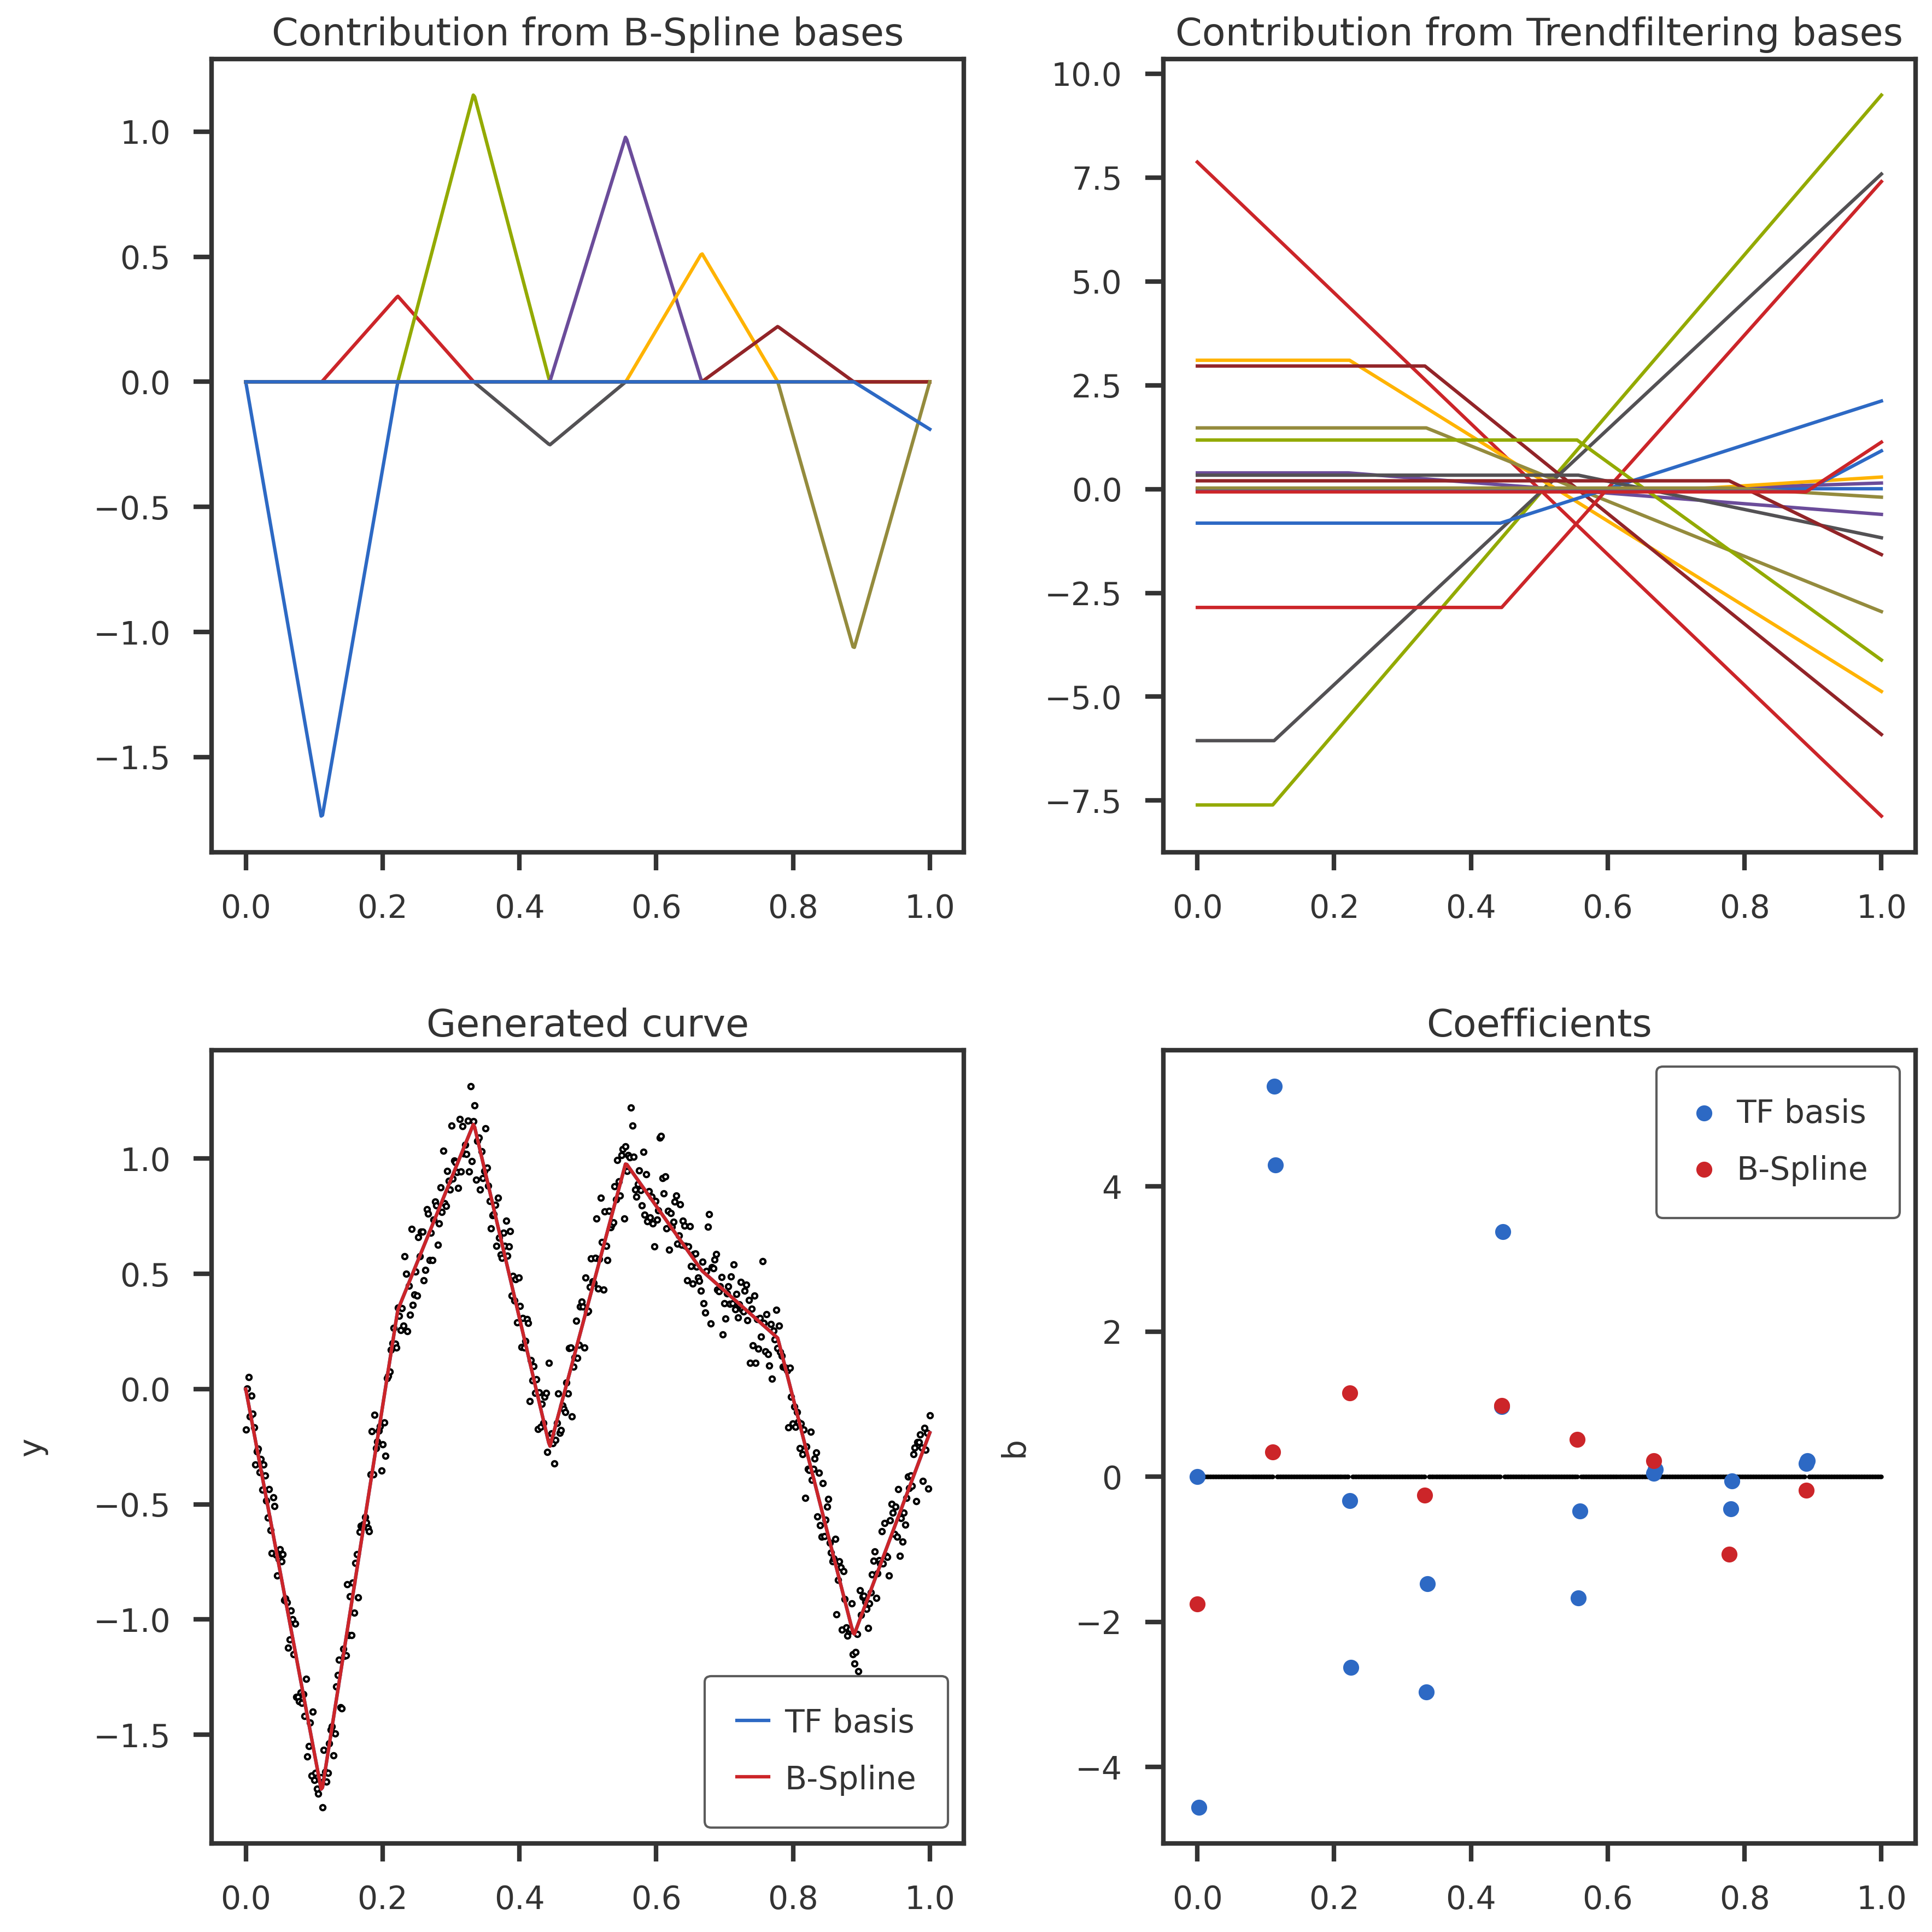

In [4]:
fig = plt.figure(figsize = (12, 12))
axlist = [fig.add_subplot(2,2,i+1) for i in range(4)]
model.plot_data_from_bspline(axlist, x, y, knots, degree, G, Gb, Hscale, bscale, show_base_legend = False)
plt.tight_layout()
plt.subplots_adjust(hspace = 0.25)
plt.show()

In [5]:
tf_y, tf_fit = R_trendfilter.fit(y, order = degree)
tf_basis_inv = model.trendfiltering_basis_matrix_inverse(n, degree) 
tf_bhat  = np.dot(tf_basis_inv, tf_y)

R[write to console]: Loading required package: Matrix



Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 



In [20]:
k = 20
scale = 4.0
s2init = np.var(y - np.dot(H, tf_bhat))
_, binit = center_and_scale_tfbasis(H, tf_bhat)
winit, sk = initialize_ash_prior(k, scale = scale, sparsity = 0.8)
print (r"Standard deviation of components in Gaussian scale mixture:")
print (', '.join([f"{x:.3f}" for x in sk]))
print ()
print ("Coefficients of components in Gaussian scale mixture (initial values):")
print (', '.join([f"{x:.3f}" for x in winit]))

Standard deviation of components in Gaussian scale mixture:
0.000, 0.072, 0.149, 0.231, 0.320, 0.414, 0.516, 0.625, 0.741, 0.866, 1.000, 1.144, 1.297, 1.462, 1.639, 1.828, 2.031, 2.249, 2.482, 2.732

Coefficients of components in Gaussian scale mixture (initial values):
0.800, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011


In [22]:
'''
mr.ash.alpha
'''
mrash_r = MrASHR(option = "rds", debug = False)
mrash_r.fit(Hscale, y, sk, binit = binit, winit = winit, s2init = s2init, maxiter = 20000)

2022-04-06 11:39:07,904 | mrashpen.inference.mrash_wrapR | INFO | Mr.ASH terminated at iteration 10101.



In [23]:
'''
mr.ash.pen
'''
plr_lbfgs_noinit = PLR(method = 'L-BFGS-B', is_prior_scaled = True, function_call = 'fortran',
                debug = False, display_progress = False, calculate_elbo = True,
                maxiter = 2000, tol = 1e-8)
plr_lbfgs_noinit.fit(Hscale, y, sk, binit = binit, winit = winit, s2init = s2init)

mr.ash.pen terminated at iteration 871.


In [24]:
'''
mr.ash.pen (inverse)
'''
import mrashpen_inverse
from scipy import optimize as sp_optimize

def plr_obj_func_Minv(params, X, y, sk, s2, dj, softmax_base = np.exp(1)):
    n, p = X.shape
    k = sk.shape[0]
    b = params[:p]
    a = params[p:]
    r = y - np.dot(X, b)
    rTr = np.dot(r, r)
    Pb, dPdb, dPda = mrashpen_inverse.penalty_func(b, a, np.sqrt(s2), sk, dj,
                                    jac = True, 
                                    softmax_base = softmax_base, 
                                    method = 'fssi-cubic',
                                    ngrid = 500)
    H = 0.5 * rTr / s2 + Pb
    dHdb = - np.dot(r.T, X) / s2
    dHdb += dPdb
    return H, np.concatenate((dHdb, dPda))

ainit = np.log(winit)
initparams = np.concatenate((binit, ainit))
opt_min = sp_optimize.minimize(plr_obj_func_Minv, initparams,
                               args = (Hscale, y, sk, s2init, dj),
                               method = 'l-bfgs-b', jac = True,
                               #options = {'disp': True, 'maxiter': 10, 'return_all': True}
                               options = {'disp':True, 'maxiter': 20000}
                              )

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          520     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.16650D+03    |proj g|=  8.66122D+02

At iterate    1    f= -1.16699D+03    |proj g|=  8.54540D+02

At iterate    2    f= -1.16712D+03    |proj g|=  8.43016D+02

At iterate    3    f= -1.16746D+03    |proj g|=  8.42164D+02

At iterate    4    f= -1.16799D+03    |proj g|=  8.30900D+02

At iterate    5    f= -1.16882D+03    |proj g|=  7.98080D+02

At iterate    6    f= -1.17025D+03    |proj g|=  6.89971D+02

At iterate    7    f= -1.17109D+03    |proj g|=  3.18725D+02

At iterate    8    f= -1.17163D+03    |proj g|=  4.60861D+02

At iterate    9    f= -1.17291D+03    |proj g|=  1.97063D+02

At iterate   10    f= -1.17307D+03    |proj g|=  2.05966D+02

At iterate   11    f= -1.17310D+03    |proj g|=  1.85364D+02

At iterate   12    f= -1.17318D+03    |proj g|=  1.84446D+02

At iterate   13    f= -1.1

 This problem is unconstrained.



At iterate   17    f= -1.17353D+03    |proj g|=  1.76602D+02

At iterate   18    f= -1.17385D+03    |proj g|=  3.69813D+02

At iterate   19    f= -1.17474D+03    |proj g|=  4.36254D+02

At iterate   20    f= -1.17591D+03    |proj g|=  5.52198D+02

At iterate   21    f= -1.17642D+03    |proj g|=  5.36381D+02

At iterate   22    f= -1.17711D+03    |proj g|=  5.13296D+02

At iterate   23    f= -1.17779D+03    |proj g|=  3.88168D+02

At iterate   24    f= -1.17842D+03    |proj g|=  3.85614D+02

At iterate   25    f= -1.17941D+03    |proj g|=  3.70358D+02

At iterate   26    f= -1.17997D+03    |proj g|=  5.24967D+02

At iterate   27    f= -1.18038D+03    |proj g|=  5.43161D+02

At iterate   28    f= -1.18091D+03    |proj g|=  4.29438D+02

At iterate   29    f= -1.18116D+03    |proj g|=  3.26700D+02

At iterate   30    f= -1.18160D+03    |proj g|=  2.98299D+02

At iterate   31    f= -1.18181D+03    |proj g|=  2.81186D+02

At iterate   32    f= -1.18189D+03    |proj g|=  2.44288D+02

At iter


At iterate  155    f= -1.29832D+03    |proj g|=  6.78901D+01

At iterate  156    f= -1.29832D+03    |proj g|=  7.60451D+01

At iterate  157    f= -1.29834D+03    |proj g|=  1.06358D+02

At iterate  158    f= -1.29837D+03    |proj g|=  8.35950D+01

At iterate  159    f= -1.29840D+03    |proj g|=  1.13716D+02

At iterate  160    f= -1.29844D+03    |proj g|=  2.13065D+02

At iterate  161    f= -1.29849D+03    |proj g|=  2.12060D+02

At iterate  162    f= -1.29856D+03    |proj g|=  4.97474D+02

At iterate  163    f= -1.29864D+03    |proj g|=  4.81131D+02

At iterate  164    f= -1.29885D+03    |proj g|=  3.74125D+02

At iterate  165    f= -1.29889D+03    |proj g|=  2.48329D+02

At iterate  166    f= -1.29899D+03    |proj g|=  2.60563D+02

At iterate  167    f= -1.29903D+03    |proj g|=  2.11957D+02

At iterate  168    f= -1.29907D+03    |proj g|=  9.39082D+01

At iterate  169    f= -1.29907D+03    |proj g|=  2.56580D+02

At iterate  170    f= -1.29909D+03    |proj g|=  1.26249D+02

At iter


At iterate  306    f= -1.31644D+03    |proj g|=  2.07337D+02

At iterate  307    f= -1.31647D+03    |proj g|=  1.79872D+02

At iterate  308    f= -1.31651D+03    |proj g|=  2.84525D+02

At iterate  309    f= -1.31655D+03    |proj g|=  2.37965D+02

At iterate  310    f= -1.31663D+03    |proj g|=  2.71787D+02

At iterate  311    f= -1.31672D+03    |proj g|=  2.36512D+02

At iterate  312    f= -1.31675D+03    |proj g|=  3.27887D+02

At iterate  313    f= -1.31682D+03    |proj g|=  1.40482D+02

At iterate  314    f= -1.31684D+03    |proj g|=  1.37604D+02

At iterate  315    f= -1.31687D+03    |proj g|=  2.06404D+02

At iterate  316    f= -1.31695D+03    |proj g|=  5.05407D+02

At iterate  317    f= -1.31709D+03    |proj g|=  5.01596D+02

At iterate  318    f= -1.31735D+03    |proj g|=  4.13146D+02

At iterate  319    f= -1.31770D+03    |proj g|=  4.81299D+02

At iterate  320    f= -1.31804D+03    |proj g|=  5.08005D+02

At iterate  321    f= -1.31822D+03    |proj g|=  5.34162D+02

At iter


At iterate  448    f= -1.32488D+03    |proj g|=  2.94927D+02

At iterate  449    f= -1.32493D+03    |proj g|=  2.84266D+02

At iterate  450    f= -1.32511D+03    |proj g|=  2.11214D+02

At iterate  451    f= -1.32514D+03    |proj g|=  3.49425D+02

At iterate  452    f= -1.32517D+03    |proj g|=  1.86070D+02

At iterate  453    f= -1.32520D+03    |proj g|=  8.41402D+01

At iterate  454    f= -1.32520D+03    |proj g|=  2.95830D+02

At iterate  455    f= -1.32522D+03    |proj g|=  2.35739D+02

At iterate  456    f= -1.32529D+03    |proj g|=  3.41816D+02

At iterate  457    f= -1.32532D+03    |proj g|=  1.82016D+02

At iterate  458    f= -1.32536D+03    |proj g|=  1.62641D+02

At iterate  459    f= -1.32539D+03    |proj g|=  1.05761D+02

At iterate  460    f= -1.32542D+03    |proj g|=  1.63820D+02

At iterate  461    f= -1.32546D+03    |proj g|=  1.87892D+02

At iterate  462    f= -1.32554D+03    |proj g|=  1.69017D+02

At iterate  463    f= -1.32556D+03    |proj g|=  1.40210D+02

At iter


At iterate  585    f= -1.33196D+03    |proj g|=  2.38008D+02

At iterate  586    f= -1.33198D+03    |proj g|=  1.88373D+02

At iterate  587    f= -1.33199D+03    |proj g|=  1.33540D+02

At iterate  588    f= -1.33199D+03    |proj g|=  8.94557D+01

At iterate  589    f= -1.33200D+03    |proj g|=  2.88909D+02

At iterate  590    f= -1.33201D+03    |proj g|=  2.18139D+02

At iterate  591    f= -1.33204D+03    |proj g|=  2.13368D+02

At iterate  592    f= -1.33209D+03    |proj g|=  3.20896D+02

At iterate  593    f= -1.33219D+03    |proj g|=  3.26014D+02

At iterate  594    f= -1.33222D+03    |proj g|=  3.29824D+02

At iterate  595    f= -1.33224D+03    |proj g|=  2.91586D+02

At iterate  596    f= -1.33226D+03    |proj g|=  2.19500D+02

At iterate  597    f= -1.33227D+03    |proj g|=  1.98536D+02

At iterate  598    f= -1.33228D+03    |proj g|=  1.09484D+02

At iterate  599    f= -1.33228D+03    |proj g|=  2.20815D+02

At iterate  600    f= -1.33229D+03    |proj g|=  1.75112D+02

At iter


At iterate  719    f= -1.34154D+03    |proj g|=  3.29279D+02

At iterate  720    f= -1.34156D+03    |proj g|=  2.30823D+02

At iterate  721    f= -1.34157D+03    |proj g|=  1.85598D+02

At iterate  722    f= -1.34160D+03    |proj g|=  1.21589D+02

At iterate  723    f= -1.34160D+03    |proj g|=  8.99661D+01

At iterate  724    f= -1.34160D+03    |proj g|=  9.97754D+01

At iterate  725    f= -1.34161D+03    |proj g|=  7.27459D+01

At iterate  726    f= -1.34161D+03    |proj g|=  4.37671D+02

At iterate  727    f= -1.34164D+03    |proj g|=  1.84199D+02

At iterate  728    f= -1.34166D+03    |proj g|=  2.02990D+02

At iterate  729    f= -1.34173D+03    |proj g|=  2.59039D+02

At iterate  730    f= -1.34177D+03    |proj g|=  3.34089D+02

At iterate  731    f= -1.34181D+03    |proj g|=  3.11933D+02

At iterate  732    f= -1.34187D+03    |proj g|=  4.49114D+02

At iterate  733    f= -1.34195D+03    |proj g|=  4.83119D+02

At iterate  734    f= -1.34199D+03    |proj g|=  6.73059D+02

At iter


At iterate  867    f= -1.34793D+03    |proj g|=  1.05826D+02

At iterate  868    f= -1.34793D+03    |proj g|=  1.30807D+02

At iterate  869    f= -1.34794D+03    |proj g|=  1.62311D+02

At iterate  870    f= -1.34795D+03    |proj g|=  2.83974D+02

At iterate  871    f= -1.34796D+03    |proj g|=  1.21861D+02

At iterate  872    f= -1.34796D+03    |proj g|=  5.29320D+01

At iterate  873    f= -1.34796D+03    |proj g|=  9.48855D+01

At iterate  874    f= -1.34796D+03    |proj g|=  3.19011D+01

At iterate  875    f= -1.34796D+03    |proj g|=  3.10128D+01

At iterate  876    f= -1.34796D+03    |proj g|=  8.20250D+01

At iterate  877    f= -1.34797D+03    |proj g|=  1.34446D+02

At iterate  878    f= -1.34797D+03    |proj g|=  1.54219D+02

At iterate  879    f= -1.34798D+03    |proj g|=  1.64666D+02

At iterate  880    f= -1.34798D+03    |proj g|=  1.40676D+02

At iterate  881    f= -1.34799D+03    |proj g|=  9.44428D+01

At iterate  882    f= -1.34800D+03    |proj g|=  4.06679D+01

At iter


At iterate 1001    f= -1.34852D+03    |proj g|=  5.51257D+01

At iterate 1002    f= -1.34852D+03    |proj g|=  9.39790D+01

At iterate 1003    f= -1.34852D+03    |proj g|=  4.80191D+01

At iterate 1004    f= -1.34853D+03    |proj g|=  3.70695D+01

At iterate 1005    f= -1.34853D+03    |proj g|=  3.69409D+01

At iterate 1006    f= -1.34853D+03    |proj g|=  4.12880D+01

At iterate 1007    f= -1.34853D+03    |proj g|=  4.44619D+01

At iterate 1008    f= -1.34853D+03    |proj g|=  4.47503D+01

At iterate 1009    f= -1.34853D+03    |proj g|=  2.06157D+01

At iterate 1010    f= -1.34853D+03    |proj g|=  2.00160D+01

At iterate 1011    f= -1.34853D+03    |proj g|=  2.39685D+01

At iterate 1012    f= -1.34854D+03    |proj g|=  2.75385D+01

At iterate 1013    f= -1.34854D+03    |proj g|=  2.75716D+01

At iterate 1014    f= -1.34854D+03    |proj g|=  2.12456D+01

At iterate 1015    f= -1.34854D+03    |proj g|=  2.34780D+01

At iterate 1016    f= -1.34854D+03    |proj g|=  2.76086D+01

At iter


At iterate 1143    f= -1.35235D+03    |proj g|=  7.60060D+01

At iterate 1144    f= -1.35235D+03    |proj g|=  1.04409D+02

At iterate 1145    f= -1.35236D+03    |proj g|=  1.32986D+02

At iterate 1146    f= -1.35237D+03    |proj g|=  1.63260D+02

At iterate 1147    f= -1.35238D+03    |proj g|=  1.29380D+02

At iterate 1148    f= -1.35239D+03    |proj g|=  1.21426D+02

At iterate 1149    f= -1.35240D+03    |proj g|=  1.47577D+02

At iterate 1150    f= -1.35240D+03    |proj g|=  6.46487D+01

At iterate 1151    f= -1.35240D+03    |proj g|=  6.38054D+01

At iterate 1152    f= -1.35241D+03    |proj g|=  1.47724D+02

At iterate 1153    f= -1.35242D+03    |proj g|=  1.60845D+02

At iterate 1154    f= -1.35243D+03    |proj g|=  1.35538D+02

At iterate 1155    f= -1.35243D+03    |proj g|=  5.76059D+01

At iterate 1156    f= -1.35243D+03    |proj g|=  3.12649D+01

At iterate 1157    f= -1.35244D+03    |proj g|=  3.03524D+01

At iterate 1158    f= -1.35244D+03    |proj g|=  6.20643D+01

At iter


At iterate 1276    f= -1.35474D+03    |proj g|=  1.64891D+02

At iterate 1277    f= -1.35474D+03    |proj g|=  7.39637D+01

At iterate 1278    f= -1.35474D+03    |proj g|=  1.60204D+02

At iterate 1279    f= -1.35475D+03    |proj g|=  2.45906D+01

At iterate 1280    f= -1.35475D+03    |proj g|=  2.53166D+01

At iterate 1281    f= -1.35475D+03    |proj g|=  4.54788D+01

At iterate 1282    f= -1.35475D+03    |proj g|=  4.48382D+01

At iterate 1283    f= -1.35475D+03    |proj g|=  3.67458D+01

At iterate 1284    f= -1.35475D+03    |proj g|=  2.61964D+01

At iterate 1285    f= -1.35475D+03    |proj g|=  2.86505D+01

At iterate 1286    f= -1.35475D+03    |proj g|=  4.46085D+01

At iterate 1287    f= -1.35475D+03    |proj g|=  7.61652D+01

At iterate 1288    f= -1.35476D+03    |proj g|=  1.14311D+02

At iterate 1289    f= -1.35476D+03    |proj g|=  1.20687D+02

At iterate 1290    f= -1.35477D+03    |proj g|=  1.03147D+02

At iterate 1291    f= -1.35477D+03    |proj g|=  5.58989D+01

At iter


At iterate 1423    f= -1.35619D+03    |proj g|=  2.63957D+01

At iterate 1424    f= -1.35619D+03    |proj g|=  4.96001D+01

At iterate 1425    f= -1.35620D+03    |proj g|=  5.66427D+01

At iterate 1426    f= -1.35620D+03    |proj g|=  6.40653D+01

At iterate 1427    f= -1.35621D+03    |proj g|=  1.64405D+02

At iterate 1428    f= -1.35621D+03    |proj g|=  5.39057D+01

At iterate 1429    f= -1.35622D+03    |proj g|=  4.91174D+01

At iterate 1430    f= -1.35622D+03    |proj g|=  4.30217D+01

At iterate 1431    f= -1.35622D+03    |proj g|=  7.73562D+01

At iterate 1432    f= -1.35623D+03    |proj g|=  7.58917D+01

At iterate 1433    f= -1.35623D+03    |proj g|=  7.90532D+01

At iterate 1434    f= -1.35624D+03    |proj g|=  6.87827D+01

At iterate 1435    f= -1.35625D+03    |proj g|=  8.34959D+01

At iterate 1436    f= -1.35626D+03    |proj g|=  1.15094D+02

At iterate 1437    f= -1.35628D+03    |proj g|=  5.98430D+01

At iterate 1438    f= -1.35630D+03    |proj g|=  1.52648D+02

At iter


At iterate 1569    f= -1.35671D+03    |proj g|=  7.57345D+01

At iterate 1570    f= -1.35672D+03    |proj g|=  1.04664D+02

At iterate 1571    f= -1.35673D+03    |proj g|=  8.94138D+01

At iterate 1572    f= -1.35673D+03    |proj g|=  7.55146D+01

At iterate 1573    f= -1.35674D+03    |proj g|=  6.70595D+01

At iterate 1574    f= -1.35674D+03    |proj g|=  6.29455D+01

At iterate 1575    f= -1.35675D+03    |proj g|=  1.45323D+02

At iterate 1576    f= -1.35677D+03    |proj g|=  1.24865D+02

At iterate 1577    f= -1.35678D+03    |proj g|=  2.83617D+02

At iterate 1578    f= -1.35679D+03    |proj g|=  1.41074D+02

At iterate 1579    f= -1.35681D+03    |proj g|=  6.43376D+01

At iterate 1580    f= -1.35682D+03    |proj g|=  3.98533D+02

At iterate 1581    f= -1.35688D+03    |proj g|=  3.35442D+02

At iterate 1582    f= -1.35694D+03    |proj g|=  3.00231D+02

At iterate 1583    f= -1.35695D+03    |proj g|=  2.54981D+02

At iterate 1584    f= -1.35698D+03    |proj g|=  2.31559D+02

At iter


At iterate 1702    f= -1.36444D+03    |proj g|=  3.22588D+02

At iterate 1703    f= -1.36445D+03    |proj g|=  2.54153D+02

At iterate 1704    f= -1.36445D+03    |proj g|=  8.84637D+01

At iterate 1705    f= -1.36446D+03    |proj g|=  4.81149D+01

At iterate 1706    f= -1.36446D+03    |proj g|=  1.06312D+02

At iterate 1707    f= -1.36447D+03    |proj g|=  5.97452D+01

At iterate 1708    f= -1.36447D+03    |proj g|=  6.47257D+01

At iterate 1709    f= -1.36448D+03    |proj g|=  2.10756D+02

At iterate 1710    f= -1.36449D+03    |proj g|=  1.79094D+02

At iterate 1711    f= -1.36452D+03    |proj g|=  3.14044D+02

At iterate 1712    f= -1.36452D+03    |proj g|=  2.03296D+02

At iterate 1713    f= -1.36454D+03    |proj g|=  1.42096D+02

At iterate 1714    f= -1.36455D+03    |proj g|=  9.05621D+01

At iterate 1715    f= -1.36455D+03    |proj g|=  6.20642D+01

At iterate 1716    f= -1.36455D+03    |proj g|=  7.40421D+01

At iterate 1717    f= -1.36455D+03    |proj g|=  7.96651D+01

At iter


At iterate 1836    f= -1.36552D+03    |proj g|=  1.05390D+02

At iterate 1837    f= -1.36553D+03    |proj g|=  1.65920D+02

At iterate 1838    f= -1.36554D+03    |proj g|=  2.23367D+02

At iterate 1839    f= -1.36555D+03    |proj g|=  2.46554D+02

At iterate 1840    f= -1.36557D+03    |proj g|=  2.57640D+02

At iterate 1841    f= -1.36559D+03    |proj g|=  1.92387D+02

At iterate 1842    f= -1.36560D+03    |proj g|=  1.97229D+02

At iterate 1843    f= -1.36560D+03    |proj g|=  3.64158D+01

At iterate 1844    f= -1.36560D+03    |proj g|=  2.78573D+01

At iterate 1845    f= -1.36560D+03    |proj g|=  2.70009D+01

At iterate 1846    f= -1.36560D+03    |proj g|=  2.76445D+01

At iterate 1847    f= -1.36561D+03    |proj g|=  3.69476D+01

At iterate 1848    f= -1.36561D+03    |proj g|=  5.06476D+01

At iterate 1849    f= -1.36561D+03    |proj g|=  3.00131D+01

At iterate 1850    f= -1.36561D+03    |proj g|=  6.36172D+01

At iterate 1851    f= -1.36561D+03    |proj g|=  3.63429D+01

At iter


At iterate 1980    f= -1.36685D+03    |proj g|=  4.39095D+02

At iterate 1981    f= -1.36686D+03    |proj g|=  9.56251D+01

At iterate 1982    f= -1.36686D+03    |proj g|=  1.18025D+02

At iterate 1983    f= -1.36687D+03    |proj g|=  8.65984D+01

At iterate 1984    f= -1.36688D+03    |proj g|=  1.53168D+02

At iterate 1985    f= -1.36690D+03    |proj g|=  2.22424D+02

At iterate 1986    f= -1.36694D+03    |proj g|=  2.99698D+02

At iterate 1987    f= -1.36701D+03    |proj g|=  3.38963D+02

At iterate 1988    f= -1.36701D+03    |proj g|=  3.83315D+02

At iterate 1989    f= -1.36712D+03    |proj g|=  2.64703D+02

At iterate 1990    f= -1.36715D+03    |proj g|=  1.01379D+02

At iterate 1991    f= -1.36717D+03    |proj g|=  2.60018D+02

At iterate 1992    f= -1.36719D+03    |proj g|=  2.62611D+02

At iterate 1993    f= -1.36725D+03    |proj g|=  1.85615D+02

At iterate 1994    f= -1.36732D+03    |proj g|=  3.15060D+02

At iterate 1995    f= -1.36734D+03    |proj g|=  2.86190D+02

At iter


At iterate 2129    f= -1.36909D+03    |proj g|=  1.68168D+02

At iterate 2130    f= -1.36909D+03    |proj g|=  1.44623D+02

At iterate 2131    f= -1.36910D+03    |proj g|=  9.31200D+01

At iterate 2132    f= -1.36910D+03    |proj g|=  1.84793D+02

At iterate 2133    f= -1.36910D+03    |proj g|=  3.77469D+01

At iterate 2134    f= -1.36910D+03    |proj g|=  2.66294D+01

At iterate 2135    f= -1.36911D+03    |proj g|=  8.42306D+01

At iterate 2136    f= -1.36911D+03    |proj g|=  6.06871D+01

At iterate 2137    f= -1.36911D+03    |proj g|=  5.72773D+01

At iterate 2138    f= -1.36911D+03    |proj g|=  2.11168D+01

At iterate 2139    f= -1.36911D+03    |proj g|=  2.44558D+01

At iterate 2140    f= -1.36911D+03    |proj g|=  2.23624D+01

At iterate 2141    f= -1.36911D+03    |proj g|=  6.16704D+01

At iterate 2142    f= -1.36912D+03    |proj g|=  6.31876D+01

At iterate 2143    f= -1.36912D+03    |proj g|=  5.47706D+01

At iterate 2144    f= -1.36912D+03    |proj g|=  2.45932D+01

At iter


At iterate 2279    f= -1.37133D+03    |proj g|=  3.12391D+02

At iterate 2280    f= -1.37134D+03    |proj g|=  1.60744D+02

At iterate 2281    f= -1.37135D+03    |proj g|=  1.05564D+02

At iterate 2282    f= -1.37136D+03    |proj g|=  6.12260D+01

At iterate 2283    f= -1.37136D+03    |proj g|=  3.09696D+01

At iterate 2284    f= -1.37136D+03    |proj g|=  6.61260D+01

At iterate 2285    f= -1.37136D+03    |proj g|=  5.10985D+01

At iterate 2286    f= -1.37136D+03    |proj g|=  6.34626D+01

At iterate 2287    f= -1.37136D+03    |proj g|=  2.57281D+01

At iterate 2288    f= -1.37137D+03    |proj g|=  2.50462D+01

At iterate 2289    f= -1.37137D+03    |proj g|=  3.92059D+01

At iterate 2290    f= -1.37137D+03    |proj g|=  4.35799D+01

At iterate 2291    f= -1.37137D+03    |proj g|=  8.90011D+01

At iterate 2292    f= -1.37137D+03    |proj g|=  1.25326D+02

At iterate 2293    f= -1.37138D+03    |proj g|=  2.75619D+02

At iterate 2294    f= -1.37140D+03    |proj g|=  2.14322D+02

At iter


At iterate 2416    f= -1.37291D+03    |proj g|=  7.43367D+01

At iterate 2417    f= -1.37291D+03    |proj g|=  7.71622D+01

At iterate 2418    f= -1.37292D+03    |proj g|=  8.34436D+01

At iterate 2419    f= -1.37292D+03    |proj g|=  1.94468D+02

At iterate 2420    f= -1.37294D+03    |proj g|=  2.47748D+02

At iterate 2421    f= -1.37297D+03    |proj g|=  2.59661D+02

At iterate 2422    f= -1.37298D+03    |proj g|=  2.46176D+02

At iterate 2423    f= -1.37299D+03    |proj g|=  2.46284D+02

At iterate 2424    f= -1.37300D+03    |proj g|=  2.32835D+02

At iterate 2425    f= -1.37300D+03    |proj g|=  2.02724D+02

At iterate 2426    f= -1.37301D+03    |proj g|=  1.50887D+02

At iterate 2427    f= -1.37302D+03    |proj g|=  8.27645D+01

At iterate 2428    f= -1.37302D+03    |proj g|=  8.73653D+01

At iterate 2429    f= -1.37302D+03    |proj g|=  8.14574D+01

At iterate 2430    f= -1.37302D+03    |proj g|=  1.53900D+02

At iterate 2431    f= -1.37302D+03    |proj g|=  1.04452D+02

At iter


At iterate 2554    f= -1.37501D+03    |proj g|=  1.13355D+02

At iterate 2555    f= -1.37501D+03    |proj g|=  9.48272D+01

At iterate 2556    f= -1.37501D+03    |proj g|=  4.58200D+01

At iterate 2557    f= -1.37501D+03    |proj g|=  5.74753D+01

At iterate 2558    f= -1.37501D+03    |proj g|=  5.20978D+01

At iterate 2559    f= -1.37501D+03    |proj g|=  5.71345D+01

At iterate 2560    f= -1.37501D+03    |proj g|=  4.58832D+01

At iterate 2561    f= -1.37501D+03    |proj g|=  5.26547D+01

At iterate 2562    f= -1.37502D+03    |proj g|=  9.28985D+01

At iterate 2563    f= -1.37502D+03    |proj g|=  1.04833D+02

At iterate 2564    f= -1.37502D+03    |proj g|=  9.33654D+01

At iterate 2565    f= -1.37503D+03    |proj g|=  1.23269D+02

At iterate 2566    f= -1.37503D+03    |proj g|=  7.94328D+01

At iterate 2567    f= -1.37505D+03    |proj g|=  1.27841D+02

At iterate 2568    f= -1.37506D+03    |proj g|=  1.80158D+02

At iterate 2569    f= -1.37508D+03    |proj g|=  2.06829D+02

At iter


At iterate 2694    f= -1.37533D+03    |proj g|=  2.87743D+01

At iterate 2695    f= -1.37533D+03    |proj g|=  2.08081D+01

At iterate 2696    f= -1.37533D+03    |proj g|=  2.07173D+01

At iterate 2697    f= -1.37533D+03    |proj g|=  4.51799D+01

At iterate 2698    f= -1.37533D+03    |proj g|=  6.20829D+01

At iterate 2699    f= -1.37533D+03    |proj g|=  3.85319D+01

At iterate 2700    f= -1.37533D+03    |proj g|=  2.67437D+01

At iterate 2701    f= -1.37533D+03    |proj g|=  3.43334D+01

At iterate 2702    f= -1.37534D+03    |proj g|=  8.79109D+01

At iterate 2703    f= -1.37534D+03    |proj g|=  1.34516D+02

At iterate 2704    f= -1.37534D+03    |proj g|=  1.39587D+02

At iterate 2705    f= -1.37535D+03    |proj g|=  1.39372D+02

At iterate 2706    f= -1.37535D+03    |proj g|=  1.20838D+02

At iterate 2707    f= -1.37536D+03    |proj g|=  4.87940D+01

At iterate 2708    f= -1.37536D+03    |proj g|=  1.71101D+02

At iterate 2709    f= -1.37536D+03    |proj g|=  2.87289D+02

At iter


At iterate 2835    f= -1.37585D+03    |proj g|=  4.69636D+01

At iterate 2836    f= -1.37585D+03    |proj g|=  1.53045D+02

At iterate 2837    f= -1.37585D+03    |proj g|=  5.57552D+01

At iterate 2838    f= -1.37586D+03    |proj g|=  3.00374D+01

At iterate 2839    f= -1.37586D+03    |proj g|=  4.48790D+01

At iterate 2840    f= -1.37586D+03    |proj g|=  5.27295D+01

At iterate 2841    f= -1.37586D+03    |proj g|=  3.76510D+01

At iterate 2842    f= -1.37586D+03    |proj g|=  3.30800D+01

At iterate 2843    f= -1.37586D+03    |proj g|=  6.12460D+01

At iterate 2844    f= -1.37586D+03    |proj g|=  4.66260D+01

At iterate 2845    f= -1.37586D+03    |proj g|=  6.36972D+01

At iterate 2846    f= -1.37586D+03    |proj g|=  1.02456D+02

At iterate 2847    f= -1.37587D+03    |proj g|=  1.28679D+02

At iterate 2848    f= -1.37587D+03    |proj g|=  1.11211D+02

At iterate 2849    f= -1.37587D+03    |proj g|=  9.25142D+01

At iterate 2850    f= -1.37588D+03    |proj g|=  6.13177D+01

At iter


At iterate 2975    f= -1.37616D+03    |proj g|=  8.26235D+00

At iterate 2976    f= -1.37616D+03    |proj g|=  7.72948D+00

At iterate 2977    f= -1.37616D+03    |proj g|=  1.23763D+01

At iterate 2978    f= -1.37616D+03    |proj g|=  1.72127D+01

At iterate 2979    f= -1.37616D+03    |proj g|=  1.75625D+01

At iterate 2980    f= -1.37616D+03    |proj g|=  2.20479D+01

At iterate 2981    f= -1.37616D+03    |proj g|=  1.03586D+01

At iterate 2982    f= -1.37616D+03    |proj g|=  9.68686D+00

At iterate 2983    f= -1.37616D+03    |proj g|=  1.07697D+01

At iterate 2984    f= -1.37616D+03    |proj g|=  1.54425D+01

At iterate 2985    f= -1.37616D+03    |proj g|=  1.54343D+01

At iterate 2986    f= -1.37616D+03    |proj g|=  2.05683D+01

At iterate 2987    f= -1.37616D+03    |proj g|=  1.12971D+01

At iterate 2988    f= -1.37616D+03    |proj g|=  1.16836D+01

At iterate 2989    f= -1.37616D+03    |proj g|=  2.07044D+01

At iterate 2990    f= -1.37616D+03    |proj g|=  1.99848D+01

At iter


At iterate 3122    f= -1.37630D+03    |proj g|=  1.09210D+01

At iterate 3123    f= -1.37631D+03    |proj g|=  1.56711D+01

At iterate 3124    f= -1.37631D+03    |proj g|=  1.25064D+01

At iterate 3125    f= -1.37631D+03    |proj g|=  1.35047D+01

At iterate 3126    f= -1.37631D+03    |proj g|=  1.50630D+01

At iterate 3127    f= -1.37631D+03    |proj g|=  5.55032D+01

At iterate 3128    f= -1.37631D+03    |proj g|=  2.59813D+01

At iterate 3129    f= -1.37631D+03    |proj g|=  3.99874D+01

At iterate 3130    f= -1.37631D+03    |proj g|=  6.55593D+01

At iterate 3131    f= -1.37632D+03    |proj g|=  9.56242D+01

At iterate 3132    f= -1.37633D+03    |proj g|=  1.41937D+02

At iterate 3133    f= -1.37636D+03    |proj g|=  1.75514D+02

At iterate 3134    f= -1.37636D+03    |proj g|=  1.72162D+02

At iterate 3135    f= -1.37639D+03    |proj g|=  1.57996D+02

At iterate 3136    f= -1.37640D+03    |proj g|=  6.53405D+01

At iterate 3137    f= -1.37640D+03    |proj g|=  9.43293D+01

At iter


At iterate 3270    f= -1.37655D+03    |proj g|=  8.85818D+01

At iterate 3271    f= -1.37655D+03    |proj g|=  3.46888D+01

At iterate 3272    f= -1.37655D+03    |proj g|=  1.91343D+01

At iterate 3273    f= -1.37655D+03    |proj g|=  2.32846D+01

At iterate 3274    f= -1.37655D+03    |proj g|=  3.61265D+01

At iterate 3275    f= -1.37655D+03    |proj g|=  3.38918D+01

At iterate 3276    f= -1.37655D+03    |proj g|=  2.17366D+01

At iterate 3277    f= -1.37655D+03    |proj g|=  3.30457D+01

At iterate 3278    f= -1.37655D+03    |proj g|=  4.48955D+01

At iterate 3279    f= -1.37655D+03    |proj g|=  3.82977D+01

At iterate 3280    f= -1.37655D+03    |proj g|=  3.35213D+01

At iterate 3281    f= -1.37655D+03    |proj g|=  4.00467D+01

At iterate 3282    f= -1.37655D+03    |proj g|=  2.72830D+01

At iterate 3283    f= -1.37655D+03    |proj g|=  5.98842D+01

At iterate 3284    f= -1.37656D+03    |proj g|=  9.13834D+01

At iterate 3285    f= -1.37656D+03    |proj g|=  1.42707D+02

At iter


At iterate 3417    f= -1.37676D+03    |proj g|=  1.17300D+02

At iterate 3418    f= -1.37676D+03    |proj g|=  1.55542D+02

At iterate 3419    f= -1.37677D+03    |proj g|=  2.89505D+02

At iterate 3420    f= -1.37677D+03    |proj g|=  1.38806D+02

At iterate 3421    f= -1.37678D+03    |proj g|=  7.32777D+01

At iterate 3422    f= -1.37678D+03    |proj g|=  2.89737D+01

At iterate 3423    f= -1.37678D+03    |proj g|=  1.58104D+01

At iterate 3424    f= -1.37678D+03    |proj g|=  2.31169D+01

At iterate 3425    f= -1.37678D+03    |proj g|=  4.72428D+01

At iterate 3426    f= -1.37678D+03    |proj g|=  7.46942D+01

At iterate 3427    f= -1.37678D+03    |proj g|=  1.15145D+02

At iterate 3428    f= -1.37678D+03    |proj g|=  1.51487D+02

At iterate 3429    f= -1.37679D+03    |proj g|=  1.59223D+02

At iterate 3430    f= -1.37679D+03    |proj g|=  1.43146D+02

At iterate 3431    f= -1.37679D+03    |proj g|=  6.25410D+01

At iterate 3432    f= -1.37679D+03    |proj g|=  2.48100D+01

At iter


At iterate 3563    f= -1.37686D+03    |proj g|=  3.35983D+01

At iterate 3564    f= -1.37686D+03    |proj g|=  1.91611D+01

At iterate 3565    f= -1.37686D+03    |proj g|=  6.69340D+00

At iterate 3566    f= -1.37686D+03    |proj g|=  1.11659D+01

At iterate 3567    f= -1.37686D+03    |proj g|=  1.72691D+01

At iterate 3568    f= -1.37686D+03    |proj g|=  3.03068D+01

At iterate 3569    f= -1.37686D+03    |proj g|=  3.96577D+01

At iterate 3570    f= -1.37686D+03    |proj g|=  2.46597D+01

At iterate 3571    f= -1.37686D+03    |proj g|=  1.17189D+01

At iterate 3572    f= -1.37686D+03    |proj g|=  9.03341D+00

At iterate 3573    f= -1.37686D+03    |proj g|=  1.47030D+01

At iterate 3574    f= -1.37686D+03    |proj g|=  2.11139D+01

At iterate 3575    f= -1.37686D+03    |proj g|=  3.21114D+01

At iterate 3576    f= -1.37686D+03    |proj g|=  3.28541D+01

At iterate 3577    f= -1.37686D+03    |proj g|=  2.11955D+01

At iterate 3578    f= -1.37686D+03    |proj g|=  1.36126D+01

At iter


At iterate 3711    f= -1.37697D+03    |proj g|=  4.22215D+01

At iterate 3712    f= -1.37697D+03    |proj g|=  1.88061D+01

At iterate 3713    f= -1.37697D+03    |proj g|=  1.92933D+01

At iterate 3714    f= -1.37697D+03    |proj g|=  1.94536D+01

At iterate 3715    f= -1.37697D+03    |proj g|=  2.54174D+01

At iterate 3716    f= -1.37697D+03    |proj g|=  3.86810D+01

At iterate 3717    f= -1.37697D+03    |proj g|=  3.75209D+01

At iterate 3718    f= -1.37698D+03    |proj g|=  7.67580D+01

At iterate 3719    f= -1.37698D+03    |proj g|=  3.67595D+01

At iterate 3720    f= -1.37698D+03    |proj g|=  1.63121D+01

At iterate 3721    f= -1.37698D+03    |proj g|=  1.44375D+01

At iterate 3722    f= -1.37698D+03    |proj g|=  2.55379D+01

At iterate 3723    f= -1.37698D+03    |proj g|=  4.41725D+01

At iterate 3724    f= -1.37698D+03    |proj g|=  5.90455D+01

At iterate 3725    f= -1.37698D+03    |proj g|=  9.82410D+01

At iterate 3726    f= -1.37698D+03    |proj g|=  6.32461D+01

At iter


At iterate 3859    f= -1.37726D+03    |proj g|=  2.54511D+01

At iterate 3860    f= -1.37726D+03    |proj g|=  3.12079D+01

At iterate 3861    f= -1.37726D+03    |proj g|=  1.29489D+01

At iterate 3862    f= -1.37726D+03    |proj g|=  1.20281D+01

At iterate 3863    f= -1.37726D+03    |proj g|=  1.33756D+01

At iterate 3864    f= -1.37726D+03    |proj g|=  2.11927D+01

At iterate 3865    f= -1.37726D+03    |proj g|=  2.06021D+01

At iterate 3866    f= -1.37726D+03    |proj g|=  1.50604D+01

At iterate 3867    f= -1.37726D+03    |proj g|=  1.47154D+01

At iterate 3868    f= -1.37726D+03    |proj g|=  2.89269D+01

At iterate 3869    f= -1.37726D+03    |proj g|=  4.85501D+01

At iterate 3870    f= -1.37726D+03    |proj g|=  5.41473D+01

At iterate 3871    f= -1.37726D+03    |proj g|=  3.67314D+01

At iterate 3872    f= -1.37726D+03    |proj g|=  1.22300D+01

At iterate 3873    f= -1.37726D+03    |proj g|=  1.00711D+01

At iterate 3874    f= -1.37726D+03    |proj g|=  1.32564D+01

At iter


At iterate 4011    f= -1.37784D+03    |proj g|=  9.13791D+01

At iterate 4012    f= -1.37784D+03    |proj g|=  1.59674D+02

At iterate 4013    f= -1.37784D+03    |proj g|=  1.95738D+02

At iterate 4014    f= -1.37784D+03    |proj g|=  1.87273D+02

At iterate 4015    f= -1.37785D+03    |proj g|=  8.70550D+01

At iterate 4016    f= -1.37785D+03    |proj g|=  1.48910D+02

At iterate 4017    f= -1.37785D+03    |proj g|=  1.62545D+02

At iterate 4018    f= -1.37786D+03    |proj g|=  2.05402D+02

At iterate 4019    f= -1.37786D+03    |proj g|=  1.42222D+02

At iterate 4020    f= -1.37786D+03    |proj g|=  4.23920D+01

At iterate 4021    f= -1.37786D+03    |proj g|=  5.56317D+01

At iterate 4022    f= -1.37786D+03    |proj g|=  5.91302D+01

At iterate 4023    f= -1.37786D+03    |proj g|=  6.78499D+01

At iterate 4024    f= -1.37786D+03    |proj g|=  2.13404D+02

At iterate 4025    f= -1.37787D+03    |proj g|=  1.06071D+02

At iterate 4026    f= -1.37787D+03    |proj g|=  4.40067D+01

At iter


At iterate 4163    f= -1.37836D+03    |proj g|=  7.48101D+01

At iterate 4164    f= -1.37836D+03    |proj g|=  1.04368D+02

At iterate 4165    f= -1.37836D+03    |proj g|=  9.05410D+01

At iterate 4166    f= -1.37836D+03    |proj g|=  6.61102D+01

At iterate 4167    f= -1.37836D+03    |proj g|=  2.72327D+01

At iterate 4168    f= -1.37836D+03    |proj g|=  3.43516D+01

At iterate 4169    f= -1.37836D+03    |proj g|=  3.31302D+01

At iterate 4170    f= -1.37836D+03    |proj g|=  4.57249D+01

At iterate 4171    f= -1.37836D+03    |proj g|=  7.74821D+01

At iterate 4172    f= -1.37836D+03    |proj g|=  2.43125D+01

At iterate 4173    f= -1.37836D+03    |proj g|=  2.44595D+01

At iterate 4174    f= -1.37836D+03    |proj g|=  3.81408D+01

At iterate 4175    f= -1.37836D+03    |proj g|=  6.62968D+01

At iterate 4176    f= -1.37836D+03    |proj g|=  1.13589D+02

At iterate 4177    f= -1.37836D+03    |proj g|=  1.74300D+02

At iterate 4178    f= -1.37837D+03    |proj g|=  2.50704D+02

At iter


At iterate 4310    f= -1.37908D+03    |proj g|=  1.11445D+02

At iterate 4311    f= -1.37909D+03    |proj g|=  1.63975D+02

At iterate 4312    f= -1.37909D+03    |proj g|=  2.19461D+02

At iterate 4313    f= -1.37910D+03    |proj g|=  4.14946D+02

At iterate 4314    f= -1.37910D+03    |proj g|=  1.48803D+02

At iterate 4315    f= -1.37911D+03    |proj g|=  1.13395D+02

At iterate 4316    f= -1.37911D+03    |proj g|=  7.08994D+01

At iterate 4317    f= -1.37911D+03    |proj g|=  7.37533D+01

At iterate 4318    f= -1.37912D+03    |proj g|=  1.23947D+02

At iterate 4319    f= -1.37912D+03    |proj g|=  2.11792D+02

At iterate 4320    f= -1.37913D+03    |proj g|=  2.74708D+02

At iterate 4321    f= -1.37913D+03    |proj g|=  2.76580D+02

At iterate 4322    f= -1.37914D+03    |proj g|=  2.84469D+02

At iterate 4323    f= -1.37914D+03    |proj g|=  1.83501D+02

At iterate 4324    f= -1.37914D+03    |proj g|=  4.72569D+01

At iterate 4325    f= -1.37914D+03    |proj g|=  2.95341D+01

At iter


At iterate 4453    f= -1.37989D+03    |proj g|=  1.25852D+02

At iterate 4454    f= -1.37989D+03    |proj g|=  1.38442D+02

At iterate 4455    f= -1.37989D+03    |proj g|=  1.10087D+02

At iterate 4456    f= -1.37989D+03    |proj g|=  3.19124D+01

At iterate 4457    f= -1.37989D+03    |proj g|=  4.55789D+01

At iterate 4458    f= -1.37989D+03    |proj g|=  3.17483D+01

At iterate 4459    f= -1.37989D+03    |proj g|=  5.84388D+01

At iterate 4460    f= -1.37989D+03    |proj g|=  8.83714D+01

At iterate 4461    f= -1.37989D+03    |proj g|=  1.05953D+02

At iterate 4462    f= -1.37989D+03    |proj g|=  8.04035D+01

At iterate 4463    f= -1.37989D+03    |proj g|=  2.77818D+01

At iterate 4464    f= -1.37989D+03    |proj g|=  2.30703D+01

At iterate 4465    f= -1.37990D+03    |proj g|=  7.92953D+01

At iterate 4466    f= -1.37990D+03    |proj g|=  1.46046D+02

At iterate 4467    f= -1.37990D+03    |proj g|=  2.11532D+02

At iterate 4468    f= -1.37991D+03    |proj g|=  2.30391D+02

At iter

At iterate 4590    f= -1.38033D+03    |proj g|=  6.73027D+01

At iterate 4591    f= -1.38033D+03    |proj g|=  8.31311D+01

At iterate 4592    f= -1.38033D+03    |proj g|=  8.71064D+01

At iterate 4593    f= -1.38033D+03    |proj g|=  6.47066D+01

At iterate 4594    f= -1.38033D+03    |proj g|=  6.01101D+01

At iterate 4595    f= -1.38033D+03    |proj g|=  1.38995D+01

At iterate 4596    f= -1.38033D+03    |proj g|=  1.81276D+01

At iterate 4597    f= -1.38033D+03    |proj g|=  2.97437D+01

At iterate 4598    f= -1.38033D+03    |proj g|=  4.96384D+01

At iterate 4599    f= -1.38033D+03    |proj g|=  6.83662D+01

At iterate 4600    f= -1.38033D+03    |proj g|=  4.66854D+01

At iterate 4601    f= -1.38033D+03    |proj g|=  9.12185D+00

At iterate 4602    f= -1.38033D+03    |proj g|=  4.81106D+01

At iterate 4603    f= -1.38033D+03    |proj g|=  6.67129D+01

At iterate 4604    f= -1.38033D+03    |proj g|=  1.08987D+02

At iterate 4605    f= -1.38033D+03    |proj g|=  1.51029D+02

At itera


At iterate 4730    f= -1.38053D+03    |proj g|=  5.02625D+01

At iterate 4731    f= -1.38053D+03    |proj g|=  6.52167D+01

At iterate 4732    f= -1.38053D+03    |proj g|=  1.78917D+02

At iterate 4733    f= -1.38054D+03    |proj g|=  1.80334D+02

At iterate 4734    f= -1.38054D+03    |proj g|=  6.41131D+01

At iterate 4735    f= -1.38054D+03    |proj g|=  6.56756D+01

At iterate 4736    f= -1.38054D+03    |proj g|=  1.92667D+02

At iterate 4737    f= -1.38055D+03    |proj g|=  1.24355D+02

At iterate 4738    f= -1.38055D+03    |proj g|=  1.35630D+02

At iterate 4739    f= -1.38055D+03    |proj g|=  1.78156D+02

At iterate 4740    f= -1.38056D+03    |proj g|=  2.52224D+02

At iterate 4741    f= -1.38056D+03    |proj g|=  2.07524D+02

At iterate 4742    f= -1.38056D+03    |proj g|=  1.91131D+02

At iterate 4743    f= -1.38057D+03    |proj g|=  1.48721D+02

At iterate 4744    f= -1.38057D+03    |proj g|=  1.18772D+02

At iterate 4745    f= -1.38057D+03    |proj g|=  6.20954D+01

At iter


At iterate 4870    f= -1.38081D+03    |proj g|=  2.90156D+01

At iterate 4871    f= -1.38081D+03    |proj g|=  2.42725D+01

At iterate 4872    f= -1.38082D+03    |proj g|=  5.78869D+01

At iterate 4873    f= -1.38082D+03    |proj g|=  9.49493D+01

At iterate 4874    f= -1.38082D+03    |proj g|=  1.82686D+02

At iterate 4875    f= -1.38082D+03    |proj g|=  1.41717D+02

At iterate 4876    f= -1.38082D+03    |proj g|=  1.33404D+02

At iterate 4877    f= -1.38082D+03    |proj g|=  7.20869D+01

At iterate 4878    f= -1.38082D+03    |proj g|=  4.83445D+01

At iterate 4879    f= -1.38082D+03    |proj g|=  1.61946D+01

At iterate 4880    f= -1.38082D+03    |proj g|=  1.57412D+01

At iterate 4881    f= -1.38082D+03    |proj g|=  2.23217D+01

At iterate 4882    f= -1.38082D+03    |proj g|=  6.87482D+01

At iterate 4883    f= -1.38082D+03    |proj g|=  1.37916D+02

At iterate 4884    f= -1.38082D+03    |proj g|=  1.85776D+02

At iterate 4885    f= -1.38082D+03    |proj g|=  2.34044D+02

At iter


At iterate 5011    f= -1.38094D+03    |proj g|=  2.91026D+01

At iterate 5012    f= -1.38094D+03    |proj g|=  5.38197D+01

At iterate 5013    f= -1.38094D+03    |proj g|=  4.68183D+01

At iterate 5014    f= -1.38094D+03    |proj g|=  5.14637D+01

At iterate 5015    f= -1.38094D+03    |proj g|=  1.82611D+01

At iterate 5016    f= -1.38094D+03    |proj g|=  7.16102D+00

At iterate 5017    f= -1.38094D+03    |proj g|=  1.06648D+01

At iterate 5018    f= -1.38094D+03    |proj g|=  3.35712D+01

At iterate 5019    f= -1.38094D+03    |proj g|=  6.17814D+01

At iterate 5020    f= -1.38094D+03    |proj g|=  9.03029D+01

At iterate 5021    f= -1.38094D+03    |proj g|=  1.31094D+02

At iterate 5022    f= -1.38094D+03    |proj g|=  1.05237D+02

At iterate 5023    f= -1.38094D+03    |proj g|=  6.86518D+01

At iterate 5024    f= -1.38094D+03    |proj g|=  1.02808D+01

At iterate 5025    f= -1.38094D+03    |proj g|=  7.15395D+00

At iterate 5026    f= -1.38094D+03    |proj g|=  7.28802D+00

At iter


At iterate 5158    f= -1.38112D+03    |proj g|=  5.46557D+01

At iterate 5159    f= -1.38112D+03    |proj g|=  4.04096D+01

At iterate 5160    f= -1.38112D+03    |proj g|=  1.46726D+01

At iterate 5161    f= -1.38112D+03    |proj g|=  9.37760D+00

At iterate 5162    f= -1.38112D+03    |proj g|=  1.09162D+01

At iterate 5163    f= -1.38112D+03    |proj g|=  2.70207D+01

At iterate 5164    f= -1.38112D+03    |proj g|=  4.64754D+01

At iterate 5165    f= -1.38112D+03    |proj g|=  6.06931D+01

At iterate 5166    f= -1.38112D+03    |proj g|=  5.24658D+01

At iterate 5167    f= -1.38112D+03    |proj g|=  3.05035D+01

At iterate 5168    f= -1.38112D+03    |proj g|=  1.47618D+01

At iterate 5169    f= -1.38112D+03    |proj g|=  3.23362D+01

At iterate 5170    f= -1.38112D+03    |proj g|=  5.41285D+01

At iterate 5171    f= -1.38112D+03    |proj g|=  8.07449D+01

At iterate 5172    f= -1.38112D+03    |proj g|=  1.10825D+02

At iterate 5173    f= -1.38112D+03    |proj g|=  1.36983D+02

At iter


At iterate 5291    f= -1.38120D+03    |proj g|=  1.48610D+01

At iterate 5292    f= -1.38120D+03    |proj g|=  1.34884D+01

At iterate 5293    f= -1.38120D+03    |proj g|=  4.07039D+01

At iterate 5294    f= -1.38120D+03    |proj g|=  7.54757D+01

At iterate 5295    f= -1.38120D+03    |proj g|=  7.96177D+01

At iterate 5296    f= -1.38120D+03    |proj g|=  6.98765D+01

At iterate 5297    f= -1.38120D+03    |proj g|=  4.04107D+01

At iterate 5298    f= -1.38120D+03    |proj g|=  7.25974D+01

At iterate 5299    f= -1.38120D+03    |proj g|=  9.11535D+01

At iterate 5300    f= -1.38120D+03    |proj g|=  3.14858D+02

At iterate 5301    f= -1.38120D+03    |proj g|=  1.54685D+02

At iterate 5302    f= -1.38121D+03    |proj g|=  6.27529D+01

At iterate 5303    f= -1.38121D+03    |proj g|=  2.96018D+01

At iterate 5304    f= -1.38121D+03    |proj g|=  2.03256D+01

At iterate 5305    f= -1.38121D+03    |proj g|=  1.36650D+01

At iterate 5306    f= -1.38121D+03    |proj g|=  9.91217D+00

At iter

In [25]:
bhat = opt_min.x[:binit.shape[0]]
what = mrashpen_inverse.softmax(opt_min.x[binit.shape[0]:])

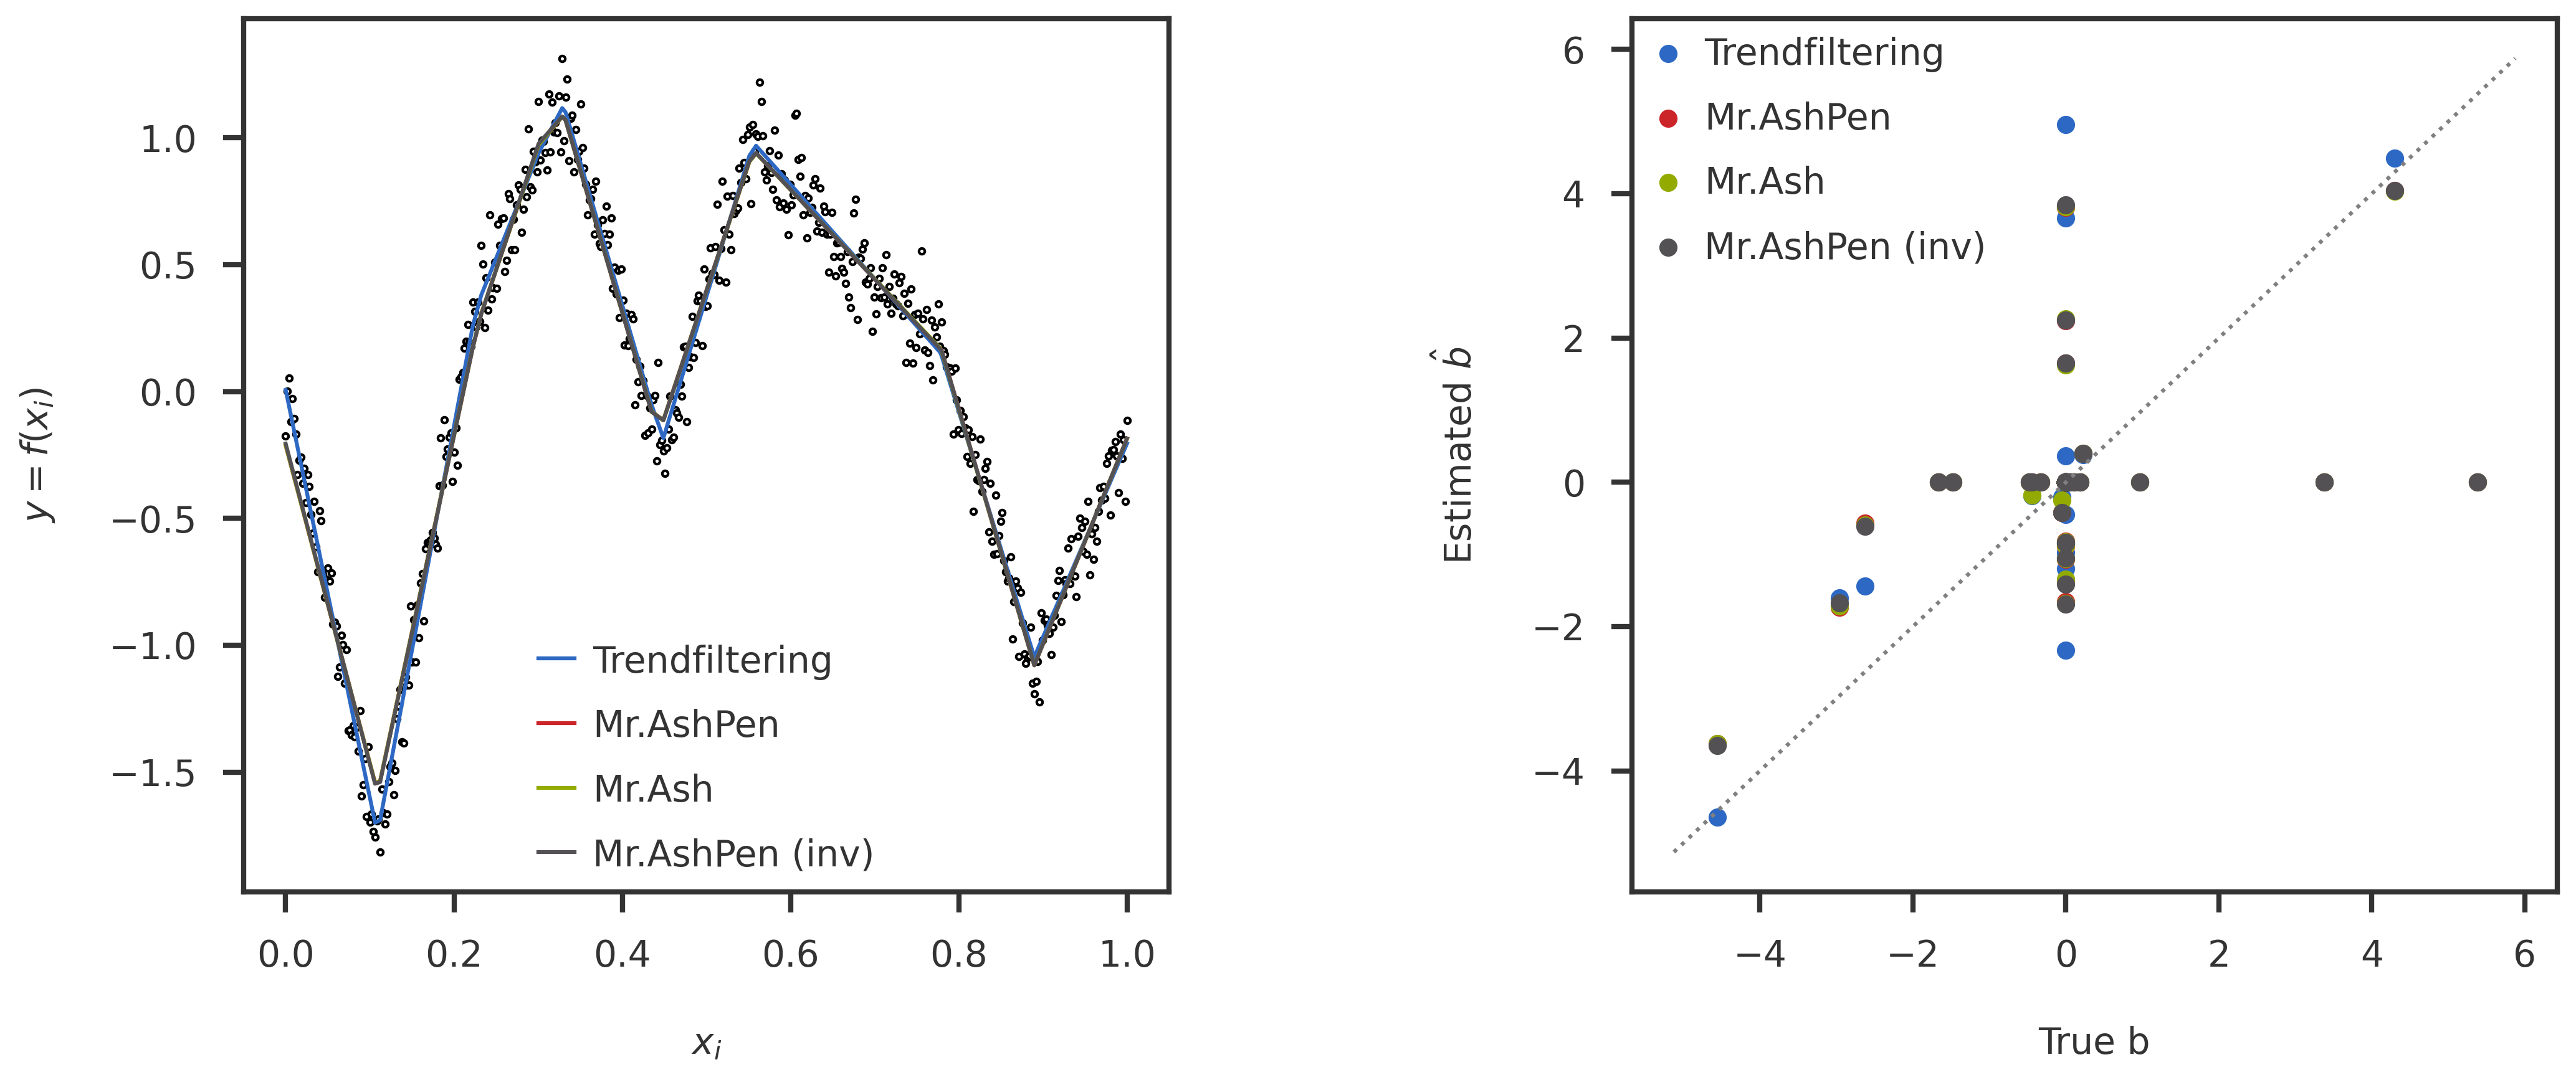

In [26]:
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.scatter(x, y, s = 5, edgecolor = 'black', facecolor='white')
#ax1.plot(x, np.dot(H, btrue), label = "True")
ax1.plot(x, tf_y, label = "Trendfiltering")
ax1.plot(x, np.dot(Hscale, plr_lbfgs_noinit.coef), label = "Mr.AshPen")
ax1.plot(x, np.dot(Hscale, mrash_r.coef), label = "Mr.Ash")
ax1.plot(x, np.dot(Hscale, bhat), label = "Mr.AshPen (inv)")
ax1.legend()

ax1.set_xlabel(r"$x_i$")
ax1.set_ylabel(r"$y = f(x_i)$")
ax2.scatter(bscale, binit, label = "Trendfiltering")
ax2.scatter(bscale, plr_lbfgs_noinit.coef, label = "Mr.AshPen")
ax2.scatter(bscale, mrash_r.coef, label = "Mr.Ash")
ax2.scatter(bscale, bhat, label = "Mr.AshPen (inv)")
mpl_utils.plot_diag(ax2)
ax2.set_xlabel("True b")
ax2.set_ylabel(r"Estimated $\hat{b}$")
ax2.legend()
plt.tight_layout()
plt.subplots_adjust(wspace = 0.5)
plt.show()

# fig = plt.figure(figsize = (12, 6))
# ax1 = fig.add_subplot(111)
# objs = [mrash_r.obj_path, plr_lbfgs_noinit.elbo_path]
# methods = ["Mr.Ash", "Mr.AshPen"]
# nwarm = [0, 0]
# objmin  = np.min([np.min(x) for x in objs])
# for obj, method, iteq in zip(objs, methods, nwarm):
#     m_obj = np.array(obj)[iteq:] - objmin
#     m_obj = m_obj[m_obj > 0]
#     ax1.plot(range(iteq, len(m_obj) + iteq), np.log10(m_obj), label = method, 
#              marker = 'o', markersize = 1)
# ax1.legend()
# ax1.set_xlabel("Number of Iterations")
# ax1.set_ylabel("log( max(ELBO) - ELBO )")
# plt.show()

### Coefficients of components in Gaussian scale mixture

In [27]:
print ("Mr.Ash:")
print (', '.join([f"{x:.3f}" for x in mrash_r.prior[:, 0]]))
print ()

print ("Mr.AshPen:")
print (', '.join([f"{x:.3f}" for x in plr_lbfgs_noinit.prior]))
print ()

print ("Mr.AshPen (using M-inverse):")
print (', '.join([f"{x:.3f}" for x in what]))
print ()

Mr.Ash:
0.969, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.031

Mr.AshPen:
0.971, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.028

Mr.AshPen (using M-inverse):
0.971, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.028

